# Libraries import

In [1]:
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from brian2 import *
import pandas as pd
from scipy import signal
from brian2hears import *
import csv

# Normal data loading and plots

In [2]:
ibf_normal_exp1=scipy.io.loadmat('baseline_1.mat')
ibf_normal_exp2=scipy.io.loadmat('baseline_2.mat')
ibf_normal_exp3=scipy.io.loadmat('baseline_3.mat')

ibf_normal_exp1 = ibf_normal_exp1["bearing"][0][0][1]
ibf_normal_exp2 = ibf_normal_exp2["bearing"][0][0][1]
ibf_normal_exp3 = ibf_normal_exp3["bearing"][0][0][1]

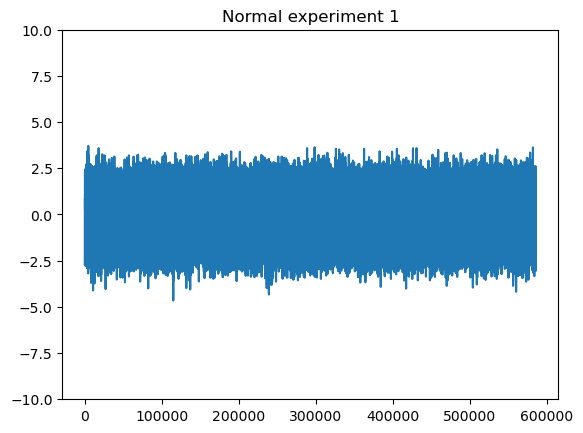

In [3]:
plt.plot(ibf_normal_exp1)
plt.title("Normal experiment 1")
plt.ylim(-10,10)
plt.show()

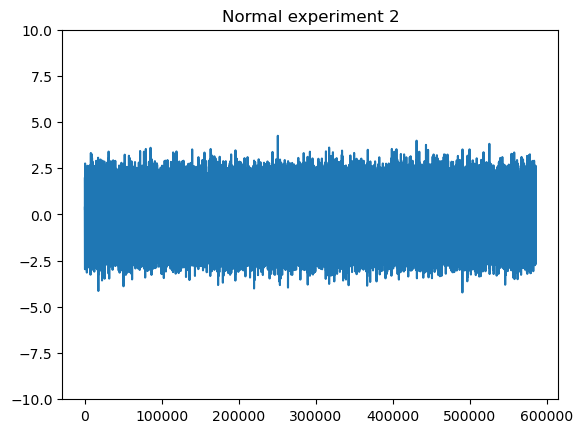

In [4]:
plt.plot(ibf_normal_exp2)
plt.title("Normal experiment 2")
plt.ylim(-10,10)
plt.show()

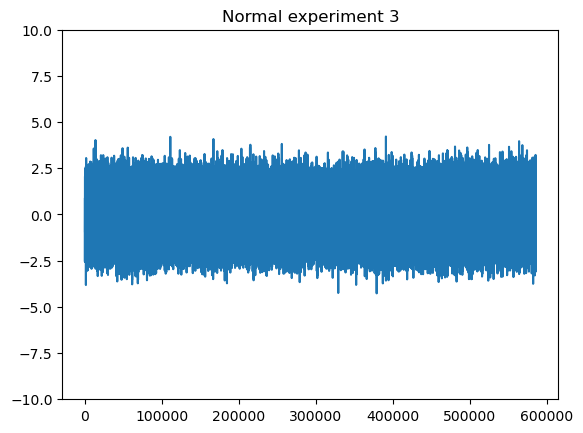

In [5]:
plt.plot(ibf_normal_exp3)
plt.title("Normal experiment 3")
plt.ylim(-10,10)
plt.show()

# Anomaly data loading and plots

In [6]:
ibf_anomaly_exp4 = scipy.io.loadmat('OuterRaceFault_1.mat')
ibf_anomaly_exp5 = scipy.io.loadmat('OuterRaceFault_2.mat')
ibf_anomaly_exp6 = scipy.io.loadmat('OuterRaceFault_3.mat')

ibf_anomaly_exp4 = ibf_anomaly_exp4["bearing"][0][0][2]
ibf_anomaly_exp5 = ibf_anomaly_exp5["bearing"][0][0][2]
ibf_anomaly_exp6 = ibf_anomaly_exp6["bearing"][0][0][2]

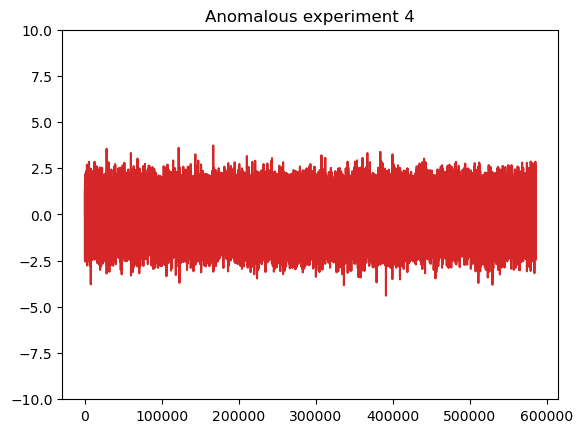

In [7]:
plt.plot(ibf_anomaly_exp4,color="tab:red")
plt.title("Anomalous experiment 4")
plt.ylim(-10,10)
plt.show()

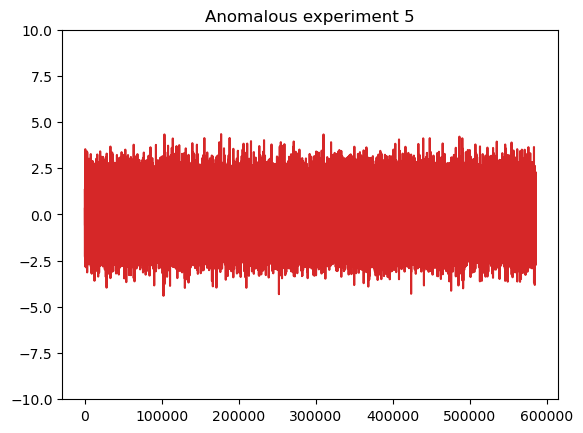

In [8]:
plt.plot(ibf_anomaly_exp5,color="tab:red")
plt.title("Anomalous experiment 5")
plt.ylim(-10,10)
plt.show()

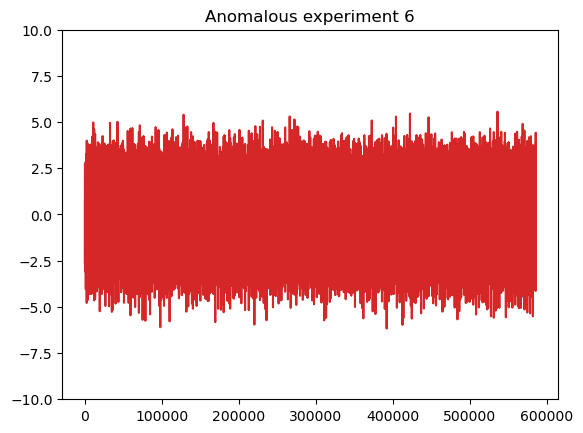

In [9]:
plt.plot(ibf_anomaly_exp6,color="tab:red")
plt.title("Anomalous experiment 6")
plt.ylim(-10,10)
plt.show()

# Gammatone filter processing

In [10]:
SAMPLE_RATE = 97656
N_OF_CHANNELS = 16

In [11]:
center_freqs = np.logspace(np.log10(40),np.log10(48828),N_OF_CHANNELS)
center_frequencies = Quantity(center_freqs*Hz)

In [12]:
center_freqs

array([4.00000000e+01, 6.42441993e+01, 1.03182929e+02, 1.65722616e+02,
       2.66167919e+02, 4.27493622e+02, 6.86599636e+02, 1.10275110e+03,
       1.77113403e+03, 2.84462720e+03, 4.56876992e+03, 7.33792413e+03,
       1.17854765e+04, 1.89287126e+04, 3.04014996e+04, 4.88280000e+04])

In [13]:
signal_normal_exp1 = Sound(ibf_normal_exp1,samplerate=SAMPLE_RATE*Hz)
signal_normal_exp2 = Sound(ibf_normal_exp2,samplerate=SAMPLE_RATE*Hz)
signal_normal_exp3 = Sound(ibf_normal_exp3,samplerate=SAMPLE_RATE*Hz)

signal_anomaly_exp4 = Sound(ibf_anomaly_exp4,samplerate=SAMPLE_RATE*Hz)
signal_anomaly_exp5 = Sound(ibf_anomaly_exp5,samplerate=SAMPLE_RATE*Hz)
signal_anomaly_exp6 = Sound(ibf_anomaly_exp6,samplerate=SAMPLE_RATE*Hz)

In [14]:
gammatone1 = Gammatone(signal_normal_exp1, center_frequencies)
gammatone_normal_exp1 = gammatone1.process()

gammatone2 = Gammatone(signal_normal_exp2, center_frequencies)
gammatone_normal_exp2 = gammatone2.process()

gammatone3 = Gammatone(signal_normal_exp3, center_frequencies)
gammatone_normal_exp3 = gammatone3.process()

gammatone4 = Gammatone(signal_anomaly_exp4, center_frequencies)
gammatone_anomaly_exp4 = gammatone4.process()

gammatone5 = Gammatone(signal_anomaly_exp5, center_frequencies)
gammatone_anomaly_exp5 = gammatone5.process()

gammatone6 = Gammatone(signal_anomaly_exp6, center_frequencies)
gammatone_anomaly_exp6 = gammatone6.process()

WARNING    Removing unsupported flag '-march=native' from compiler flags. [brian2.codegen.cpp_prefs]


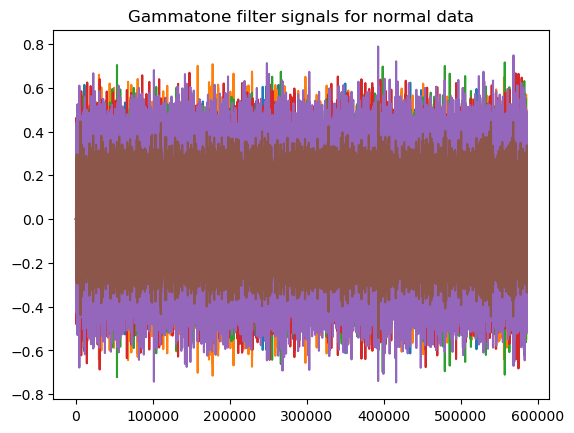

In [15]:
for i in range(gammatone_normal_exp1.shape[1]):
    plt.plot(gammatone_normal_exp1[:,i])
plt.title("Gammatone filter signals for normal data")
plt.show()

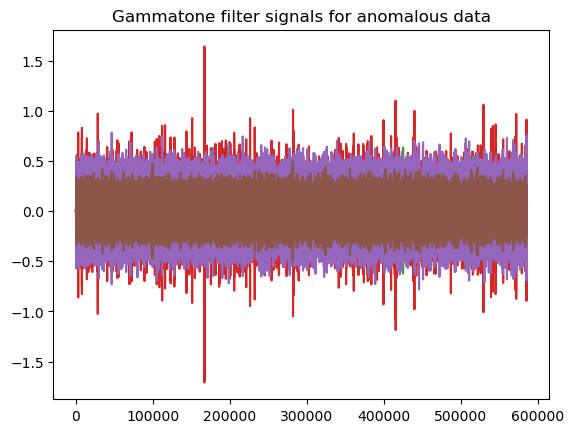

In [16]:
for i in range(gammatone_anomaly_exp4.shape[1]):
    plt.plot(gammatone_anomaly_exp4[:,i])
plt.title("Gammatone filter signals for anomalous data")
plt.show()

# Delta modulation and spikes generation

In [17]:
REFRACTORY_TIME = 0.0003
PLOT = False

In [18]:
def generate_spikes(V_in, V_up, V_dn, f_s, t_r, debug=True):
    dt = 1/f_s
    T = len(V_in)*dt
    times = np.linspace(0,T,num=len(V_in), endpoint=False)
    V_dc = V_in[0]
    freeze = 0
    spike_times_up = []
    spike_times_dn = []
    recon_signal = []
    for t in range(len(times)):
        if freeze >= 0:
            freeze -= dt
        else:
            if (V_dc + V_up) < V_in[t]:
                spike_times_up.append(times[t])
                V_dc = V_in[t]
                freeze = t_r
            if (V_dc - V_dn) > V_in[t]:
                spike_times_dn.append(times[t])
                V_dc = V_in[t]
                freeze = t_r
        recon_signal.append(V_dc)
    if debug:
        print("Spikes ratio: ", len(spike_times_up)/len(times))
        print("Spikes: ", len(spike_times_up))
    return spike_times_up, spike_times_dn,recon_signal

In [19]:
def process_signal(signal):

    spike_train = []
    indices = []
    times = []

    values = np.arange(10,18,0.5)
    signal_sound = Sound(signal, samplerate=SAMPLE_RATE*Hz)
    gammatone = Gammatone(signal_sound, center_frequencies)
    gammatone_data = gammatone.process()
    for i in range(N_OF_CHANNELS):
        thr = np.var(gammatone_data[:,i][0:len(signal//2)])*values[i]
        spk_array,_,_ = generate_spikes(gammatone_data[:,i],thr,thr,f_s=SAMPLE_RATE,t_r=REFRACTORY_TIME, debug=False)
        spike_train.append(spk_array)
    
    for ch in range(len(spike_train)):
        indices.extend([ch]*len(spike_train[ch]))
        times.extend(spike_train[ch])
    times *= second
    
    return indices, times

#  BSNN model definition

In [20]:
start_scope()

N = 16          # Number of input and hidden neurons
tau = 140*ms    # Membrane time constant
E_l =-70.6*mV   # Resting potential
V_th= -40.4*mV  # Neuron threshold voltage
V_r= -70.6*mV   # Reset voltage
E = 1 * mV 
dt = 10*usecond
taupre = taupost = 20*ms # STDP and reverse STDP time constants
gmax = 3 # Maximum synaptic weight

# LIF model equation
eqs = '''
    dvm/dt= (E_l - vm)/ tau: volt
'''

# STDP and reverse STDP trace update values
dApre_inh = (gmax/(N-1))/10
dApre_exc = (gmax/(N-1))/100

dApost_inh = dApre_inh
dApost_exc = dApre_exc

# BSNN model definition
G_input = SpikeGeneratorGroup(N, [], []*ms, dt=dt)
G_hidden = NeuronGroup(N, eqs, threshold='vm>V_th', reset='vm = V_r', method='euler',dt=dt)
G_output = NeuronGroup(1, eqs, threshold='vm>V_th', reset='vm = V_r', method='euler',dt=dt)

# Excitatory synapses
S_exc = Synapses(G_input, G_hidden,
         '''
            w : 1
            lr : 1
            dApre_exc/dt = -Apre_exc / taupre : 1 (event-driven)
            dApost_exc/dt = -Apost_exc / taupost : 1 (event-driven)
            ''',
         on_pre='''
                vm += E * w
                Apre_exc += dApre_exc
                w = clip(w + lr*Apost_exc, 0, gmax)
                ''',
         on_post='''
                    Apost_exc += dApost_exc
                    w = clip(w - lr*Apre_exc, 0, gmax)
                 ''',dt=dt)
S_exc.connect(i='j')
S_exc.w = gmax

# Inhibitory synapses
S_inh = Synapses(G_input, G_hidden,
         '''
            w : 1
            lr : 1
            dApre_inh/dt = -Apre_inh / taupre : 1 (event-driven)
            dApost_inh/dt = -Apost_inh / taupost : 1 (event-driven)
            ''',
         on_pre='''
                 vm -= E * w
                 Apre_inh += dApre_inh
                 w = clip(w - lr*Apost_inh, 0, gmax)
                ''',
         on_post='''
                    Apost_inh += dApost_inh
                    w = clip(w + lr*Apre_inh, 0, gmax)
                 ''',dt=dt)
         
S_inh.connect(condition='i!=j')
S_inh.w = gmax/(N-1)

# Output synapses
S_out = Synapses(G_hidden, G_output,'w:volt', on_pre='vm+=w',dt=dt)
S_out.connect()
S_out.w = np.abs(V_th)/N

WARNING    'i' is an internal variable of group 'synapses_1', but also exists in the run namespace with the value 15. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [21]:
def plot_results(state, spikes):
    duration = (state.t[-1] - state.t[0])/second
    time_shift = magic_network.t - duration*second
    out_spikes=spikes.spike_trains()
    fig, axs = plt.subplots(2)
    xlabel('Time (s)')
    axs[0].set(ylabel='Membrane potential (mV)')
    axs[1].set(ylabel='Spikes')
    axs[1].set_yticks([])
    
    axs[0].plot(out_statemon.t - time_shift, out_statemon.vm[0]*1000)
    axs[1].vlines(x=[out_spikes[0][1:] - time_shift],ymin=0,ymax=0.5,color="black")
    axs[0].hlines(y=[-40.6],xmin=0,xmax=duration,color="tab:red",label="Neuron threshold voltage ($V_{th}$)")
    axs[1].set_xlim([0,duration])
    axs[0].legend()

In [22]:
def run_net(mode, signals, spike_tol=0):
    
    ### Reset network ###
    S_exc.Apre_exc = 0
    S_exc.Apost_exc = 0
    S_inh.Apre_inh = 0
    S_inh.Apost_inh = 0
    G_hidden.vm = 0
    G_output.vm = 0
    ### Reset network ###

    if mode == "train":
        S_exc.lr = 1
        S_inh.lr = 1
        print("Training...")
        while True:
            out_statemon = StateMonitor(G_output, variables=["vm"],record=0)
            out_spikemon = SpikeMonitor(G_output)
            for signal in signals:
                indices, times = process_signal(signal)
                G_input.set_spikes(indices, times + magic_network.t)
                run(len(signal)*(1/SAMPLE_RATE)*second)
            print("# of output spikes: " + str(out_spikemon.num_spikes))

            ### Reset network ###
            S_exc.Apre_exc = 0
            S_exc.Apost_exc = 0
            S_inh.Apre_inh = 0
            S_inh.Apost_inh = 0
            G_hidden.vm = 0
            G_output.vm = 0
            ### Reset network ###
            
            if out_spikemon.num_spikes <= spike_tol:
                print("Training finished")
                break
                
    elif mode == "test":
        S_exc.lr = 0
        S_inh.lr = 0
        print("Testing...")
        out_statemon = StateMonitor(G_output, variables=["vm"],record=0)
        out_spikemon = SpikeMonitor(G_output)
        for signal in signals:
            indices, times = process_signal(signal)
            G_input.set_spikes(indices, times + magic_network.t)
            run(len(signal)*(1/SAMPLE_RATE)*second)
        print("# of output spikes: " + str(out_spikemon.num_spikes))

    return out_statemon, out_spikemon

## BSNN training on normal experiment

In [23]:
out_statemon, out_spikemon = run_net("train", [ibf_normal_exp1, ibf_normal_exp1], 30)

Training...
# of output spikes: 25
Training finished


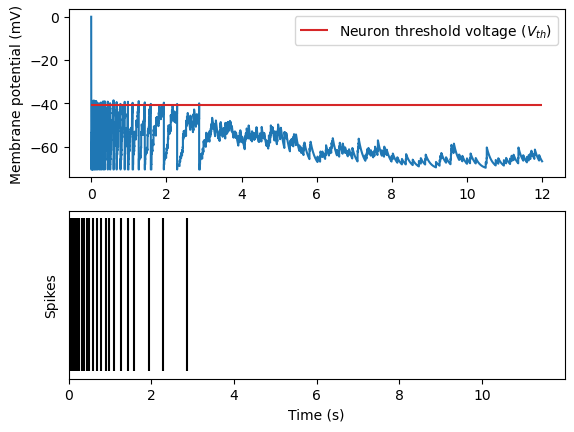

In [24]:
plot_results(out_statemon, out_spikemon)

## BSNN test

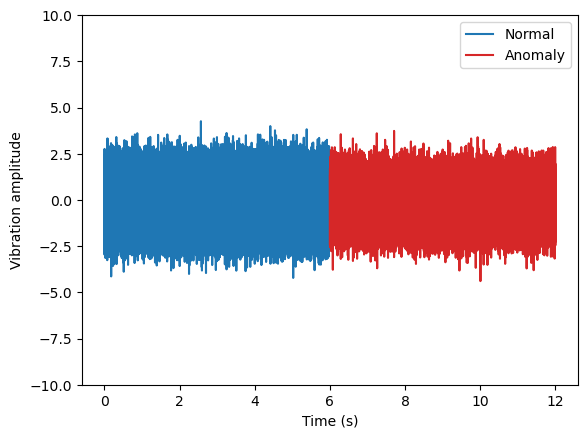

In [25]:
test_signal = np.concatenate((np.zeros((len(ibf_normal_exp2),1))*np.nan,ibf_anomaly_exp4),axis=0)
plt.plot(np.arange(len(ibf_normal_exp2))*(1/SAMPLE_RATE),ibf_normal_exp2,color="tab:blue",label="Normal")
plt.plot(np.arange(len(test_signal))*(1/SAMPLE_RATE),test_signal,color="tab:red",label="Anomaly")
plt.ylim(-10,10)
plt.ylabel("Vibration amplitude")
plt.xlabel("Time (s)")
plt.legend(loc="best")
plt.show()

In [26]:
out_statemon, out_spikemon = run_net("test", [ibf_normal_exp2, ibf_anomaly_exp4])

Testing...
# of output spikes: 23


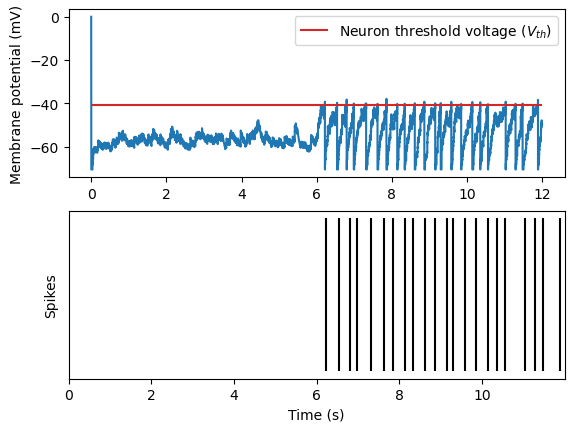

In [27]:
plot_results(out_statemon, out_spikemon)

# Experiments - Simulating real time processing

In [ ]:
def real_time_inference(signal1, signal2, window_size):
    """
    Remember to concat a normal and an anomalous signal.
    The first one will be automatically labeled as normal; the second one as anomalous.
    """
    
    ### Reset network ###
    G_hidden.vm = E_l
    G_output.vm = E_l
    S_exc.Apre_exc = 0
    S_exc.Apost_exc = 0
    S_inh.Apre_inh = 0
    S_inh.Apost_inh = 0
    ### Reset network ###

    
    out_statemon = StateMonitor(G_output,variables=["vm"],record=0)
    out_spikemon = SpikeMonitor(G_output)
    start_signal = randint(0, len(signal1))
    signal1 = signal1[start_signal:]
    
    preprocess_time = 0
    start_time = magic_network.t
    first_anomalous_sample_time = (len(signal1) + 1)*1/SAMPLE_RATE
    anomaly_window_start= floor((len(signal1) + 1) / window_size) * (window_size/SAMPLE_RATE)
    
    signal_comb = np.concatenate((signal1, signal2),axis=0)

    step_size = window_size
    loop_end = int(step_size * ceil(len(signal_comb)/step_size))

    values = np.arange(10,18,0.5)
    
    for i in range(0, loop_end, step_size):
        spike_train = []
        window = signal_comb[i:i+window_size]

        if len(window) == window_size:
            
            signal = Sound(window, samplerate=SAMPLE_RATE*Hz)
            gammatone = Gammatone(signal, center_frequencies)

            start_preprocess = time.time()
            gammatone_data = gammatone.process()
            for i in range(N_OF_CHANNELS):
                thr = np.var(gammatone_data[:,i])*values[i]
                spk_array_up,_,_ = generate_spikes(gammatone_data[:,i],thr,thr,f_s=SAMPLE_RATE,t_r=REFRACTORY_TIME, debug=False)
                spike_train.append(spk_array_up)
            end_preprocess = time.time()
            if (end_preprocess - start_preprocess) > preprocess_time:
                preprocess_time = (end_preprocess - start_preprocess)
            
            indices = []
            times = []
            
            for ch in range(len(spike_train)):
                indices.extend([ch]*len(spike_train[ch]))
                times.extend(spike_train[ch])
            times *= second
            
            G_input.set_spikes(indices, times+magic_network.t)
            
            out_spikemon_w = SpikeMonitor(G_output)
            run(window_size*(1/SAMPLE_RATE)*second)
            
            if out_spikemon_w.num_spikes > 0:
                break
                
    
    sampling_time = (window_size*1/SAMPLE_RATE)
    anomaly_to_spike = out_spikemon.t[0]/second - (start_time/second + first_anomalous_sample_time)
    first_spike_time = out_spikemon.t[0]/second - (start_time/second + first_anomalous_sample_time) + (window_size*1/SAMPLE_RATE) + preprocess_time


    if (out_spikemon.t[0] - start_time)/second - anomaly_window_start > 0:
        writer.writerow([window_size, first_anomalous_sample_time, sampling_time, preprocess_time, first_spike_time])
    
    ### Reset network ###
    G_hidden.vm = E_l
    G_output.vm = E_l
    S_exc.Apre_exc = 0
    S_exc.Apost_exc = 0
    S_inh.Apre_inh = 0
    S_inh.Apost_inh = 0
    ### Reset network ###

    return out_statemon

In [ ]:
header = ['window_size', 'anomaly_start_time', 'sampling_time',
          'preprocessing_time', 'time_to_detection']

In [ ]:
windows = [1000,1500,2000,2500,3000,5000,10000,15000,20000,25000,30000]
for win in windows:
    csv_file = open(f"{win}.csv",mode='w', newline='')
    writer = csv.writer(csv_file)
    writer.writerow(header)
    for i in range(50):
        out_state = real_time_inference(ibf_normal_exp2, ibf_anomaly_exp4, win)
    csv_file.close()